# Optimizing Bankruptcy Prediction with K-NN, ROSE

## Introduction

### Project Background

The possibility of a company facing bankruptcy is a major concern in the economic and financial field. Predicting bankruptcy early can reduce risks and provide stakeholders with valuable information to make informed decisions. The project aims to leverage machine learning techniques to predict the probability of bankruptcy based on financial metrics. We particularly address the challenges posed by unbalanced datasets, which are common in bankruptcy prediction scenarios where the number of solvent companies far exceeds the number of insolvent companies.

### Main Question

Can we accurately predict the likelihood of a company facing bankruptcy by applying *Random Over-Sampling Examples (ROSE)* for data balancing, *K-NN* for classification? (That is, we are trying to build a model that can predict whether a company will go bankrupt)

### Dataset Description

The dataset chosen for this project is from Kaggle (https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/data) , which comprises various financial indicators of American public companies listed on the New York Stock Exchange and NASDAQ over a period. It includes features such as current assets, market value, inventorys, depreciation and amortization etc. The target variable is binary, indicating whether a company went bankrupt or remained solvent within the time frame studied.

## Preliminary Exploratory Data Analysis

### Read the dataset from internet

First, we install and load the ***tidyverse*** and ***tidymodel*** libraries we're going to use:

In [1]:
# install.packages("tidyverse")
# install.packages("tidymodels")
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then we download the dataset from our github repository (https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv) and split the dataset to training and testing sets:

In [2]:
url = "https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv"
download.file(url, "data.csv")

raw_data <- read_csv("data.csv") |>
    mutate(status_label = as_factor(status_label))

head(raw_data)

bank_split <- initial_split(raw_data, prop = 0.75, strata = status_label)  
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

Rows: 78682 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): company_name, status_label
dbl (19): year, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,⋯,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,⋯,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,⋯,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,⋯,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,⋯,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,⋯,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
C_1,alive,2004,474.542,598.172,27.950,61.774,255.477,15.453,127.121,⋯,747.848,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074


### Clean and wrangle the dataset

As we can see from the dataset above, there is only one single observation in each row, only one single variable in each column (X1 to X 18 have their own names, for convenience we will convert them into readable labels later), and each value is a single cell. Therefore, we claim that this dataset is already in the tidy format, no more action needed.

### Data Observation

We can observe the training set by counting first:

In [3]:
print(paste("# of Rows:", nrow(bank_train)))
print(paste("# of Columns:", ncol(bank_train)))

[1] "# of Rows: 59011"
[1] "# of Columns: 21"


As we can see, there are 59011 rows and 21 columns in the training set.

Then, we summarize some statistics for the training set:

In [4]:
bank_train |>
    pivot_longer(X1:X18, names_to = "Factors", values_to = "Values") |>
    group_by(Factors) |>
    summarize("# of Missing" = sum(is.na(Values), na.rm = TRUE),
             "# of Unique" = n_distinct(Values, na.rm = TRUE),
             "min" = min(Values, na.rm = TRUE),
             "max" = max(Values, na.rm = TRUE),
             "mean" = mean(Values, na.rm = TRUE),
             "Standard Deviation" = sd(Values, na.rm = TRUE),
             "percentile_25" = quantile(Values, 0.25, na.rm = TRUE),
             "percentile_75" = quantile(Values, 0.75, na.rm = TRUE)) |>
    mutate(Factors_numeric = as.numeric(gsub("X", "", Factors))) |>
    arrange(Factors_numeric) |>
    select(-Factors_numeric)

Factors,# of Missing,# of Unique,min,max,mean,Standard Deviation,percentile_25,percentile_75
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,0,51082,-2.4980,169662,880.2464,3910.4608,18.80700,434.5780
X2,0,50946,-366.6450,374623,1595.1705,8941.1427,16.99300,637.6200
X3,0,29566,0.0000,28430,120.5478,645.4022,1.17500,47.9185
X4,0,46721,-21913.0000,81730,377.4691,2027.0383,-0.79950,139.9350
X5,0,31070,0.0000,47257,201.2157,1027.6163,0.00200,75.4525
X6,0,44351,-56121.9000,104821,130.7353,1253.8744,-7.42500,40.4405
X7,0,39610,0.0000,65812,286.2314,1324.1424,3.29300,132.3310
X8,0,58375,0.0005,1073391,3387.2325,17930.3004,34.69995,1240.6098
X9,0,52679,-1964.9990,511729,2366.9237,11975.0351,27.46450,1051.6780


### Target Column Distribution

We use *pie()* function to make a pie chart of our target column:

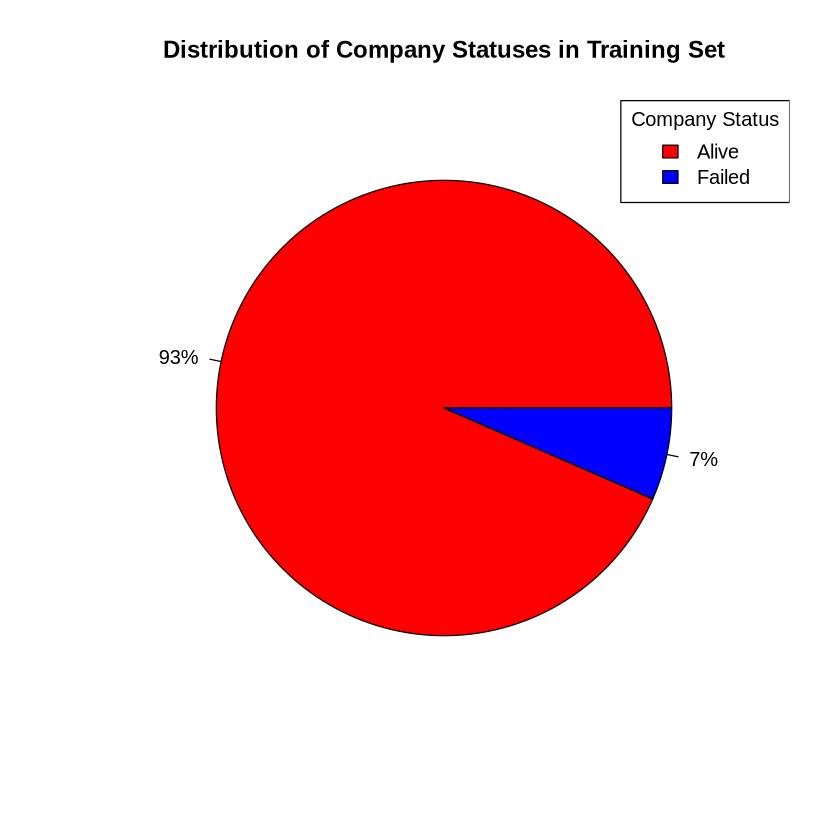

In [5]:
set.seed(1000)

alive <- filter(bank_train, status_label == "alive")
total_number <- nrow(bank_train)
alive_number <- nrow(alive)
failed_number <- total_number - alive_number

pie_data <- c(alive_number, failed_number)
pie_labels <- c("Alive", "Failed")
status_label <- c("Alive", "Failed")
slice_colors <- c("red", "blue")

pie(pie_data, labels = percent(pie_data / sum(pie_data)), col = slice_colors, main = "Distribution of Company Statuses in Training Set")

legend("topright",
    legend = status_label,
    fill = slice_colors,
    title = "Company Status")

The "Alive Ratio" is approximately 93% and the "Failed Ratio" is approximately 7%, which means that 93% of the samples belongs to the "Alive" class (haven't gone bankrupt) and 7% of the samples belongs to the "Failed" class (have gone bankrupt).

We could also claim that this is a highly imbalanced dataset and the model may be biased and cause problems when identifying minority groups. To address the issue, we will use some class balancing techniques like *Random Over-Sampling Examples (ROSE)* to oversample the minority class (Failed).

### Correlation Matrix

First, we install and load the ***ggplot2*** and ***reshape2*** libraries to plot the graph:

In [6]:
# install.packages("ggplot2")
# install.packages("reshape2")
library(ggplot2)
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




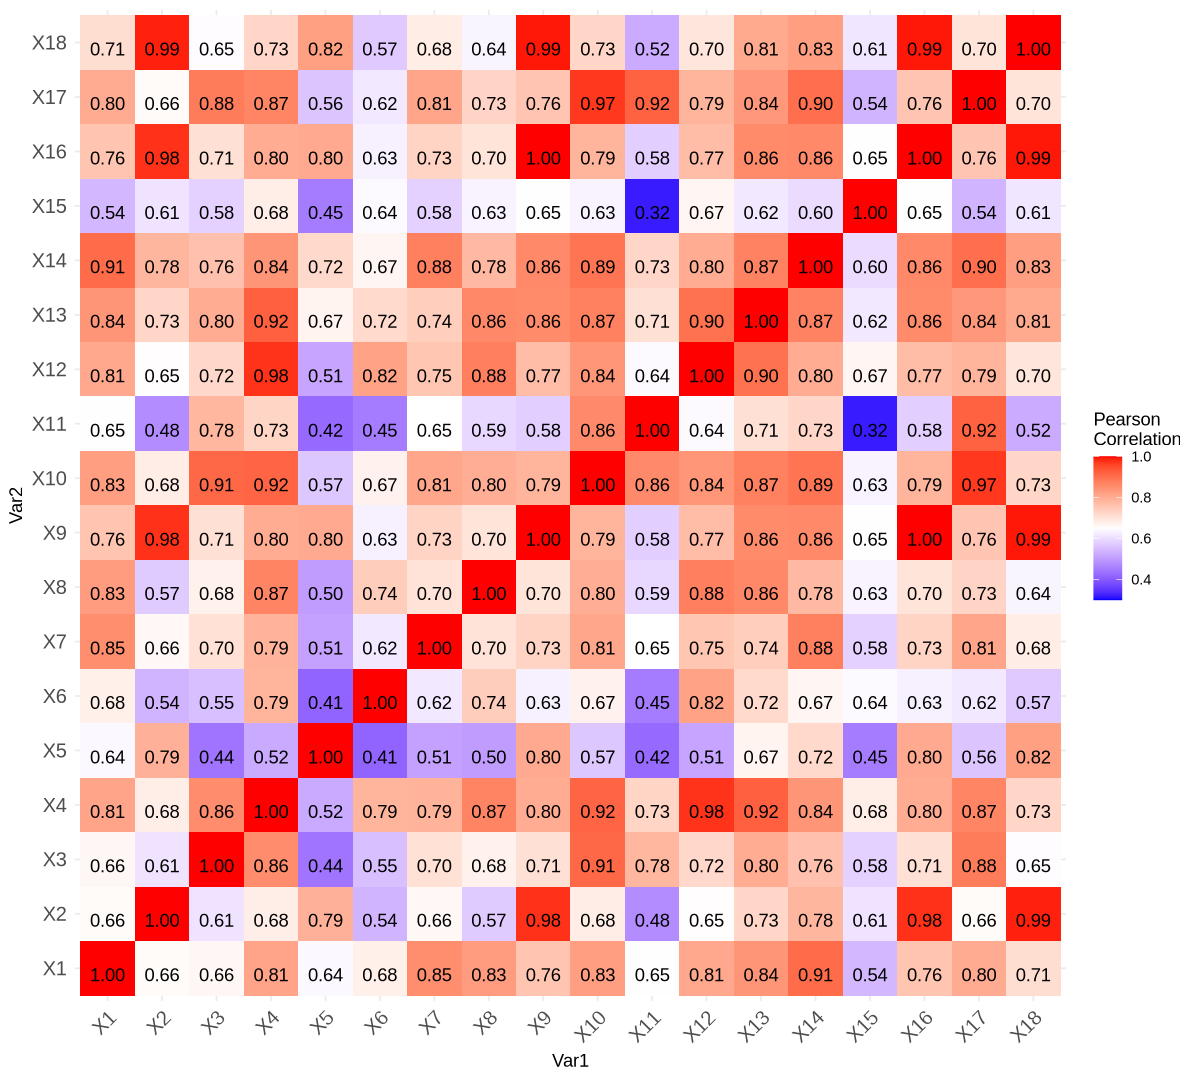

In [7]:
bank_train_select <- select(bank_train, -c(company_name, status_label, year))
cor_bank_train <- cor(bank_train_select)

long_cor <- melt(cor_bank_train)

options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(data = long_cor, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%.2f", value)), vjust = 1) +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                         midpoint = 0.65, limit = c(0.3,1), space = "Lab",
                         name="Pearson\nCorrelation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
          axis.text.y = element_text(size = 12)) +
    coord_fixed()

As we can see from the Correlation Matrix,  
- *X2*, *X9*, *X16* and *X18* are highly correlated to each other;
- *X4* and *X12* are highly correlated to each other;
- *X10*, *X11* and *X17* are highly correlated to each other.
- *X9 = X16*
- *X16 - X2 = X13*
- *X14 - X12 = X3*

## Methods

- Apply *ROSE* to oversample the failed class
- Build the main *K-NN* model with our training data.
- Use the testing data to test the accuracy of the model and enhance the model.

### Factor Choose

According to the observation we have in Correlation Matrix, and the meaning of all the factors, the predictors we will choose are as follow:  
- *X1 (Current assets)*,
- *X3 (Depreciation and amortization)*,
- *X5 (Inventory)*,
- *X7 (Total Receivables)*,
- *X8 (Market Value)*,
- *X14 (Total Current Liabilities)*,
- *X16 (Total Revenue)*,
- *X17 (Total Liabilities)*.

### Visialization

We will directly use the *Accuracy*, *Precision* and *Recall* to show how good is our model. Also, we may choose to use a *Receiver Operating Characteristic (ROC) curve* and/or the *Area Under the Curve (AUC) metric* to visualize our model, since our classification is a binary classification.

## Expected Outcomes and Significance 

### What we expect to find

We expect to find the probability that a certain company goes bankrupt based on definitive factors. (We will build a model to make prediction)

### Impact of the findings

These findings can be beneficial to potential business owners who wish to know how successful other businesses in the same fields as them are. They can also be useful to current business owners as this model can help predicting whether their business is headed towards bankruptcy or not. Also, it's valuable to investors, who could leverage these insights to make more informed decisions about their portfolios, potentially avoiding substantial losses by steering clear of companies at risk of bankruptcy. 

### Future Questions

- We may have to include the real-time data to analyse;
- Modify the model so that it could work on a specific industy with unique value or factors, so that we could make more accurate prediction;
- Change the model or apply novel machine learning innovation to improve the model.